# Identifying Protective and Risk Factors of Cardiovascular Disease 

# Introduction


### Goals:

Cardiovascular diseases (CVDs) are the leading cause of death worldwide, claiming around 17 million lives per year. Our goals for this project will be producing the best model(s) that identify and define both the protective and risk factors when it comes to predicting the prevalence of a CVD. Through the knowledge of these factors, we would be able to target the best primary prevention methods and help deter possible development of some CVDs. Our ultimate goal is to be able to differentiate the most impactful features when classifying those with and without a CVD(s). 

**Column Information:**

**Objective** Features:
(Factual Information)
- Age | Objective Feature | **age** | int (days) |
- Height | Objective Feature | **height** | int (cm) |
- Weight | Objective Feature | **weight** | float (kg) |
- Gender | Objective Feature | **gender** | categorical code |

**Examination** Features:
(Results of Medical Examination)
- Systolic blood pressure | Examination Feature | **ap_hi** --> changed to **systolic** | int |
- Diastolic blood pressure | Examination Feature | **ap_lo** --> changed to **diastolic** | int |
- Cholesterol | Examination Feature | **cholesterol** | 1: normal, 2: above normal, 3: well above normal |
- Glucose | Examination Feature | **gluc** | 1: normal, 2: above normal, 3: well above normal |

**Subjective** Features:
(Information given by the Patient)
- Smoking | Subjective Feature | **smoke** | binary |
- Alcohol intake | Subjective Feature | **alco** | binary |
- Physical activity | Subjective Feature | **active** | binary |

**Target**:

- Presence or absence of cardiovascular disease | Target Variable | **cardio** --> changed to **cvd** | binary |


# Obtain

In [30]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as stats
import sklearn
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder, FunctionTransformer
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import classification_report as cls_report
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_recall_curve, plot_confusion_matrix, plot_roc_curve
import xgboost as xgb
import time
#import shap
import pickle
import warnings
warnings.filterwarnings("ignore")

plt.style.use('ggplot')

In [31]:
df_raw = pd.read_csv('cvd.csv', sep=';', index_col='id')

# Exploring & Scrubbing

In [32]:
df_raw.head(3)

,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


In [33]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 70000 entries, 0 to 99999
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          70000 non-null  int64  
 1   gender       70000 non-null  int64  
 2   height       70000 non-null  int64  
 3   weight       70000 non-null  float64
 4   ap_hi        70000 non-null  int64  
 5   ap_lo        70000 non-null  int64  
 6   cholesterol  70000 non-null  int64  
 7   gluc         70000 non-null  int64  
 8   smoke        70000 non-null  int64  
 9   alco         70000 non-null  int64  
 10  active       70000 non-null  int64  
 11  cardio       70000 non-null  int64  
dtypes: float64(1), int64(11)
memory usage: 6.9 MB


We have all numerical columns in this dataset. The categorical columns contain both binary and ordinal values.

Numerical Columns:
- age
- height
- weight
- ap_hi
- ap_lo

Categorical Columns (Binary):
- gender
- smoke
- alco
- active
- cardio

Categorical Columns (Ordinal):
- gluc
- cholesterol

In [34]:
for col in df_raw.columns:
    print(f"{col}: {df_raw[col].nunique()}")

age: 8076
gender: 2
height: 109
weight: 287
ap_hi: 153
ap_lo: 157
cholesterol: 3
gluc: 3
smoke: 2
alco: 2
active: 2
cardio: 2


#### Renaming columns
We will be renaming some of the columns for better interpretability of what each column contains. 

In [35]:
#Renaming cols ap_hi, ap_lo, and cardio to systolic, diastolic, and cvd respectively
df_raw = df_raw.rename(columns={'ap_hi' : 'systolic', 'ap_lo': 'diastolic',
                                'cardio': 'cvd'})

In [36]:
df_raw.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,18857,1,165,64.0,130,70,3,1,0,0,0,1


#### Inspecting and dropping duplicate rows

In [37]:
# Looking for duplicated values
df_raw.duplicated().sum()

24

In [38]:
dup_df = df_raw[df_raw.duplicated(keep=False)]

We create a new dataframe containing only the duplicate values. Below, we inspect to make sure the rows within are actually duplicates.

In [39]:
# Inspecting the duplicated rows to make sure they are actually duplicates
dup_df.sort_values(by=['age']).head(10)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
57690,14552,1,158,64.0,120,80,1,1,0,0,1,0
9004,14552,1,158,64.0,120,80,1,1,0,0,1,0
91592,16160,1,168,65.0,120,80,1,1,0,0,1,1
24435,16160,1,168,65.0,120,80,1,1,0,0,1,1
1685,16793,1,165,68.0,120,80,1,1,0,0,1,0
31110,16793,1,165,68.0,120,80,1,1,0,0,1,0
40450,16805,1,157,67.0,120,80,1,1,0,0,1,0
86345,16805,1,157,67.0,120,80,1,1,0,0,1,0
63776,16937,2,170,70.0,120,80,1,1,0,0,0,0


In [40]:
#Dropping duplicates from dataframe
df_clean = df_raw.drop_duplicates()
df_clean.duplicated().sum()

0

In [41]:
len(df_clean)

69976

In [42]:
df_clean.columns

Index(['age', 'gender', 'height', 'weight', 'systolic', 'diastolic',
       'cholesterol', 'gluc', 'smoke', 'alco', 'active', 'cvd'],
      dtype='object')

#### Inspecting Class counts

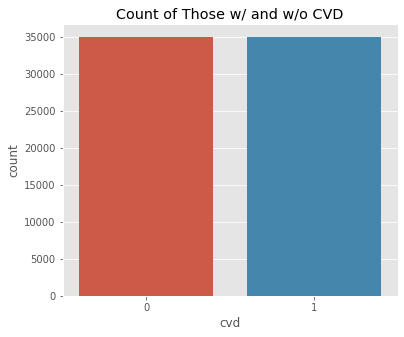

In [43]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_raw, x='cvd')
ax.set_title('Count of Those w/ and w/o CVD');

The data seems to have a very well balanced number of subjects with and without a cardiovascular disease (CVD). This dataset is most likely not representative of the actual proportion of those with a CVD.

In [44]:
df_clean['cvd'].value_counts(normalize=True).round(4)

0    0.5002
1    0.4998
Name: cvd, dtype: float64

#### Age 
We are converting age from days into years, and then plotting the age distribution. 

In [45]:
# Converting age from days to Years
df_clean['age'] = (df_clean['age'] / 365).round().astype('int')

In [46]:
df_clean['age'].describe()

count    69976.000000
mean        53.338945
std          6.765633
min         30.000000
25%         48.000000
50%         54.000000
75%         58.000000
max         65.000000
Name: age, dtype: float64

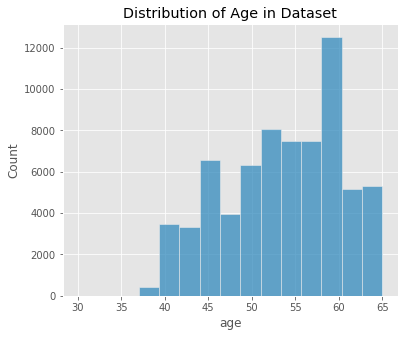

In [47]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.histplot(data=df_clean, x='age', bins=15)
ax.set_title('Distribution of Age in Dataset');

Our age range in this dataset contains patients from 30 - 65 years of age.

In [48]:
#Converting gender from (1,2) to (0,1) values
df_clean['gender'] = (df_clean['gender'] == 1).astype('int')

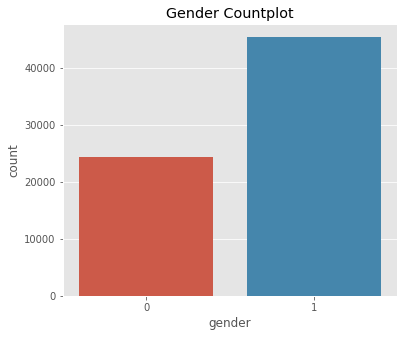

In [49]:
fig, ax = plt.subplots(figsize=(6, 5))
ax = sns.countplot(data=df_clean, x='gender')
ax.set_title('Gender Countplot');

In [50]:
df_clean['gender'].value_counts(normalize=True).round(4)

1    0.6504
0    0.3496
Name: gender, dtype: float64

### Creating Function Transformers for Age and Gender

In [51]:
def to_year(df):
    new_df = df.copy()
    new_df['age'] = (df['age'] / 365).round().astype('int')
    return new_df

In [53]:
get_year = FunctionTransformer(func=to_year)

In [57]:
def remap_gender(df):
    new_df = df.copy()
    new_df['gender'] = (df['gender'] == 1).astype('int')
    return new_df

In [58]:
get_gender = FunctionTransformer(func=remap_gender)

In [78]:
test_pipe = Pipeline(steps=[('get_year', get_year), 
                           ('get_gender', get_gender)])

test_pipe.fit_transform(df_raw).head()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd
id,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0
1,55,1,156,85.0,140,90,3,1,0,0,1,1
2,52,1,165,64.0,130,70,3,1,0,0,0,1
3,48,0,169,82.0,150,100,1,1,0,0,1,1
4,48,1,156,56.0,100,60,1,1,0,0,0,0


## Creating New Columns

#### BMI

In [61]:
# Creating a column called 'bmi'
df_clean['bmi'] = round(df_clean['weight'] / (df_clean['height']/100)**2, 2)

Formula: $weight (kg) / (height[cm]/100)^2$

According to the CDC, "Body mass index (BMI) is a person’s weight in kilograms divided by the square of height in meters. BMI is an inexpensive and easy screening method for weight category—underweight, healthy weight, overweight, and obesity."[1]

The formula for **BMI** is weight in kilograms divided by height in meters squared. If height has been measured in centimeters, divide by 100 to convert this to meters.


In [ ]:
df_clean.head(3)

#### Pulse Pressure

In [ ]:
# Creating a column called 'pulse_pressure'
df_clean['pulse_pressure'] = df_clean['systolic'] - df_clean['diastolic']

According to Yildiran, Tansel et al., "**Pulse pressure**(PP) is the difference between systolic and diastolic blood pressure (BP) values. Pulse pressure markedly rises after the 5th decade of life, due to arterial stiffening with increasing age. Several studies have shown a close relationship between high PP and the occurrence of cardiovascular (CV) death. Furthermore, high PP is a risk factor for the development of coronary heart disease, myocardial infarction, and heart failure in normotensive and hypertensive persons."[2]

In [ ]:
df_clean.describe()

### Creating BMI and Pulse Pressure Function Transformers

In [64]:
def bmi(df):
    new_df = df.copy()
    new_df['bmi'] = round(df['weight'] / (df['height']/100)**2, 2)
    return new_df

In [63]:
def pulse_pressure(df):
    new_df = df.copy()
    new_df['pulse_pressure'] = df['systolic'] - df['diastolic']
    return new_df

In [77]:
get_bmi = FunctionTransformer(func=bmi)
get_pulse_pressure = FunctionTransformer(func=pulse_pressure)

test_pipe = Pipeline(steps=[('get_year', get_year), 
                           ('get_gender', get_gender), 
                           ('get_bmi', get_bmi), 
                           ('get_pulse_pressure', get_pulse_pressure)])

test_pipe.fit_transform(df_raw).head()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure
id,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60
3,48,0,169,82.0,150,100,1,1,0,0,1,1,28.71,50
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.01,40


#### Blood Pressure Categories

In [68]:
# Creating a categorical column to determine Blood Pressure Categories
# These values are from the American Heart Association
def bp_cat(row):
    """
    Definition:
    Applies a categorical value based on a row's systolic and diastolic levels.
    These values are recognized by the American Heart Association.
    
    Args:
    row: row in the dataframe
    
    Returns:
    The Categorical value for each row.
    """
    
    if (row['systolic'] < 120) and (row['diastolic'] < 80):
        return 'normal'
    elif ((row['systolic'] >= 120) and (row['systolic'] < 130)) and (row['diastolic'] < 80):
        return 'elevated'
    elif ((row['systolic'] >= 130) and (row['systolic'] < 140)) or ((row['diastolic'] >= 80) and (row['diastolic'] < 90)):
        return 'hypertension_1'
    elif ((row['systolic'] >= 140) and row['systolic'] < 180) or ((row['diastolic'] >= 90) and row['diastolic'] < 120):
        return 'hypertension_2'
    else:
        return 'hypertension_3'
        

In [69]:
df_clean['bp_cat'] = df_clean.apply(lambda row: bp_cat(row), axis=1)

In [70]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,bp_cat
id,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,hypertension_1
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,hypertension_2
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,hypertension_1


In [71]:
df_clean['bp_cat'].value_counts()

hypertension_1    39911
hypertension_2    16915
normal             9607
elevated           3125
hypertension_3      418
Name: bp_cat, dtype: int64

### Creating Blood Pressure Category Function Transformer

In [72]:
def to_bp_cat(df):
    new_df = df.copy()
    new_df['bp_cat'] = new_df.apply(lambda row: bp_cat(row), axis=1)
    return new_df

In [76]:
get_bp_cat = FunctionTransformer(func=to_bp_cat)

test_pipe = Pipeline(steps=[('get_year', get_year), 
                           ('get_gender', get_gender), 
                           ('get_bmi', get_bmi), 
                           ('get_pulse_pressure', get_pulse_pressure), 
                           ('get_bp_cat', get_bp_cat)])

test_pipe.fit_transform(df_raw).head()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat
id,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1
3,48,0,169,82.0,150,100,1,1,0,0,1,1,28.71,50,hypertension_2
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.01,40,normal


### Creating a Frequency Plot Function

In [74]:
def frequency_plot(df, group, target, order=None, title='', xlabel='', get_df=0, 
                  figsize=(7,6)):
    """
    Definition:
    plots the percentage of no CVD to CVD in each value of a column
    
    Args:
    df = dataframe
    group = column to look at
    target = target value (CVD). Used to define the hue of the plot
    order = a list of values defined within the column
    title = the plot's title
    xlabel = the plot's xlabel
    get_df = returns df_plot if get_df=1. Default is set to 0.
    
    Returns:
    df_plot if get_df == 1.
    Plots the frequency plot using seaborn's barplot on our grouped dataframe
    """
    
    df_plot = df.groupby(group)[target].value_counts(normalize=True).\
              to_frame('frequency').reset_index()
    fig, ax = plt.subplots(figsize=(figsize))
    ax = sns.barplot(data=df_plot, x=group, y='frequency', hue=target, 
                    order=order)
    ax.set_title(title)
    if len(xlabel) > 0:
        ax.set_xlabel(xlabel)
    plt.show()
    
    if get_df:
        return df_plot

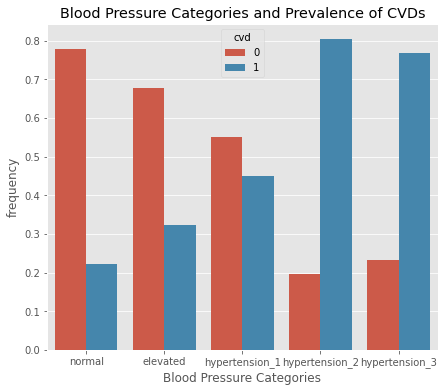

In [75]:
order = ['normal', 'elevated', 
               'hypertension_1', 'hypertension_2', 'hypertension_3']

frequency_plot(df_clean, group='bp_cat', target='cvd', order=order, 
               title='Blood Pressure Categories and Prevalence of CVDs',
              xlabel='Blood Pressure Categories')

Those who have hypertension 2 or greater are much more likely to have a CVD. Those with a normal blood pressure seem to be less likely to have a CVD. Those with hypertension 1 have a greater chance of having a CVD than those with a normal blood pressure. 

#### BMI Categories

In [79]:
def bmi_cat(row):
    """
    Definition:
    Applies a categorical value for each row in the dataframe based on the value
    of the bmi for that row. These values are recognized by the Centers for Disease
    Control and Prevention.
    
    Args:
    row = row in dataframe
    
    Returns:
    Categorical value for each row in the dataframe.
    """
    
    if (row['bmi'] < 18.5):
        return 'underweight'
    elif (row['bmi'] >= 18.5) and (row['bmi'] < 25):
        return 'normal'
    elif (row['bmi'] >= 25) and (row['bmi'] < 30):
        return 'overweight'
    else:
        return 'obese'
        

In [80]:
df_clean['bmi_cat'] = df_clean.apply(lambda row: bmi_cat(row), axis=1)

In [81]:
df_clean['bmi_cat'].value_counts()

normal         25638
overweight     25169
obese          18525
underweight      644
Name: bmi_cat, dtype: int64

In [82]:
df_clean.head(3)

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,bp_cat,bmi_cat
id,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,hypertension_1,normal
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,hypertension_2,obese
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,hypertension_1,normal


In [83]:
df_clean['bmi_cat'].unique()

array(['normal', 'obese', 'overweight', 'underweight'], dtype=object)

### Creating BMI Category Function Transformer

In [85]:
def to_bmi_cat(df):
    new_df = df.copy()
    new_df['bmi_cat'] = new_df.apply(lambda row: bmi_cat(row), axis=1)
    return new_df

In [87]:
get_bmi_cat = FunctionTransformer(func=to_bmi_cat)

test_pipe = Pipeline(steps=[('get_year', get_year), 
                           ('get_gender', get_gender), 
                           ('get_bmi', get_bmi), 
                           ('get_pulse_pressure', get_pulse_pressure), 
                           ('get_bp_cat', get_bp_cat), 
                           ('get_bmi_cat', get_bmi_cat)])

test_pipe.fit_transform(df_raw).head()

,age,gender,height,weight,systolic,diastolic,cholesterol,gluc,smoke,alco,active,cvd,bmi,pulse_pressure,bp_cat,bmi_cat
id,,,,,,,,,,,,,,,,
0,50,0,168,62.0,110,80,1,1,0,0,1,0,21.97,30,hypertension_1,normal
1,55,1,156,85.0,140,90,3,1,0,0,1,1,34.93,50,hypertension_2,obese
2,52,1,165,64.0,130,70,3,1,0,0,0,1,23.51,60,hypertension_1,normal
3,48,0,169,82.0,150,100,1,1,0,0,1,1,28.71,50,hypertension_2,overweight
4,48,1,156,56.0,100,60,1,1,0,0,0,0,23.01,40,normal,normal


### Plotting Frequency Plots for Various Features

#### Viewing BMI Categories in Frequency Plot

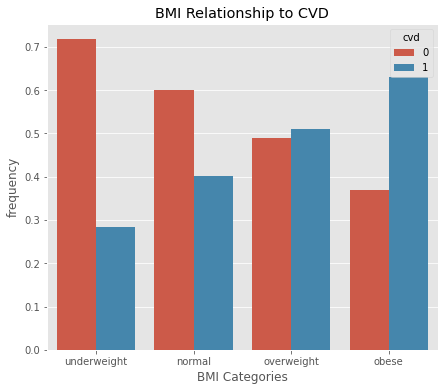

In [84]:
order = ['underweight', 'normal', 'overweight', 'obese']

frequency_plot(df_clean, group='bmi_cat', target='cvd', order=order, 
              title='BMI Relationship to CVD', xlabel='BMI Categories')

According to this graph, if a person is overweight or obese, they are more likely to have a CVD than a person who has a normal BMI. Underweight category is too small to really get anything from it. It seems like underweight is less likely to have a CVD, but we would need more datapoints in underweight to confirm that.

#### Viewing Glucose Categories in Frequency Plot

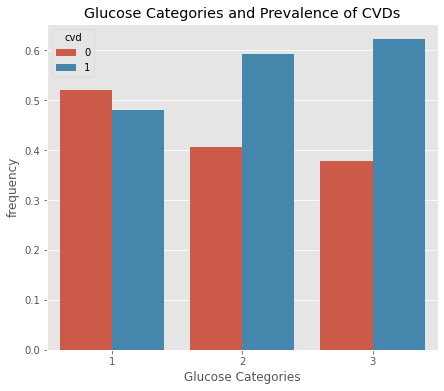

In [90]:
frequency_plot(df_clean, group='gluc', target='cvd', 
               title='Glucose Categories and Prevalence of CVDs',
              xlabel='Glucose Categories')

In [91]:
df_clean['gluc'].value_counts()

1    59455
3     5331
2     5190
Name: gluc, dtype: int64

It seems that if a person has an above normal or very above normal glucose level (2 or 3), they may be more at risk of having a CVD when compared to a person who has a normal glucose level (1).

#### Viewing Cholesterol Levels in Frequency Plot

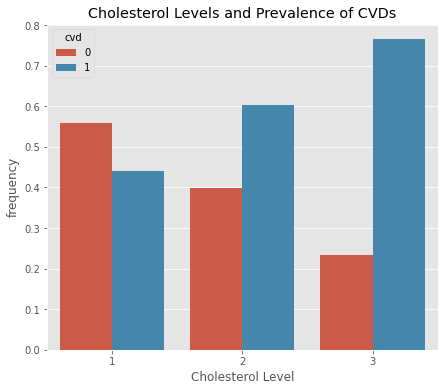

In [88]:
frequency_plot(df_clean, group='cholesterol', target='cvd', 
               title='Cholesterol Levels and Prevalence of CVDs',
              xlabel='Cholesterol Level')

In [89]:
df_clean['cholesterol'].value_counts()

1    52361
2     9549
3     8066
Name: cholesterol, dtype: int64

The higher the cholesterol level, the more common we find CVD's in patients.

#### Viewing Binary Categories

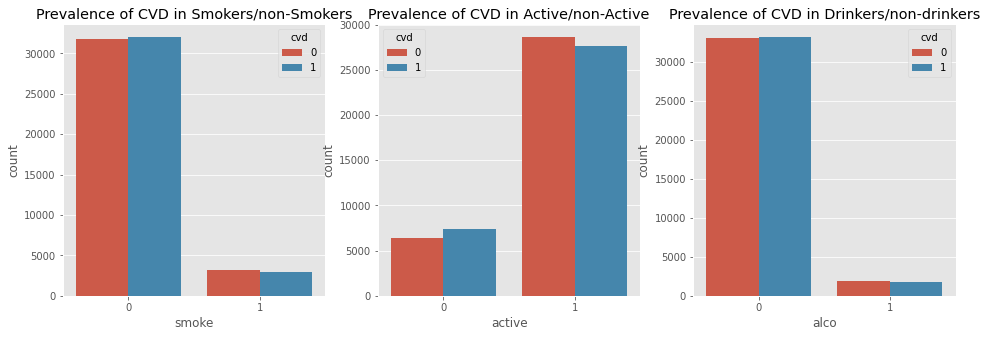

In [92]:
plt.figure(figsize=(16, 5))

plt.subplot(1, 3, 1)
sns.countplot(data=df_clean, x='smoke', hue='cvd')
plt.title('Prevalence of CVD in Smokers/non-Smokers')

plt.subplot(1, 3, 2)
sns.countplot(data=df_clean, x='active', hue='cvd')
plt.title('Prevalence of CVD in Active/non-Active')

plt.subplot(1, 3, 3)
sns.countplot(data=df_clean, x='alco', hue='cvd')
plt.title('Prevalence of CVD in Drinkers/non-drinkers');

According to these graphs, it seems that smoking and drinking do not play a factor in increasing the risk of getting a cardiovascular disease.

We must also take into account that these columns are subjective and also are only boolean values. For example, someone who drinks multiple glasses every night versus someone who drinks 2-3 glasses a week are still classified as a drinker, yet their risk of having a CVD may be different. 

#### Binning Age into Decades

In [ ]:
df_clean['age_by_decade'] = pd.cut(x=df_clean['age'], 
                                   bins=[30, 39, 49, 59, 69], 
                                   labels=['30s', '40s', '50s', '60s'], 
                                  include_lowest=True)

In [ ]:
df_clean.head(3)

In [ ]:
df_clean['age_by_decade'].value_counts()

In [ ]:
order = ['30s', '40s', '50s', '60s']

frequency_plot(df_clean, 'age_by_decade', 'cvd', order=order, 
              title='Age & Presence of CVDs', xlabel='Age Categories')

It looks like as age increases, so does the likelihood of having a Cardiovascular Disease.

In [ ]:
fig, ax = plt.subplots()
ax = sns.countplot(x='gender', hue='cvd', data=df_clean)
ax.set_title('Presence of CVD in Gender')
plt.show();

In [ ]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
sns.countplot(data=df_clean[df_clean['gender'] == 0], x='age_by_decade', 
              hue='cvd')
plt.title('Gender 0')

plt.subplot(1, 2, 2)
sns.countplot(data=df_clean[df_clean['gender'] == 1], x='age_by_decade',
              hue='cvd')
plt.title('Gender 1');

According to Rosano, Vitale, Marazzi and Volterrani, "Menopause is a risk factor for cardiovascular disease (CVD) because estrogen withdrawal has a detrimental effect on cardiovascular function and metabolism." The average age range is around 40's to 50's. After menopause women are just as likely to develop a CVD as men of the same age.

If I had to guess which gender was for women based on this graph, I would have to go with Gender 1. However, both of these graphs are very similar to one another, so it's hard to determine which is which.

In [ ]:
# Creating a dataframe containing the correlated values of each feature based on it's relationship 
# with our dependent variable, 'cvd'
df_importance = pd.DataFrame(df_clean.corr()['cvd']).\
                sort_values(by='cvd',ascending=False)

In [ ]:
# Plotting the correlations in a barplot
df_importance.plot(kind='barh');

Through correlation, we see that age, cholesterol level, weight, bmi, glucose level, diastolic, and systolic are all significant when predicting if someone may have a CVD.
Active may be significant in helping prevent the chance of developing a CVD.

## Inspecting Outliers

In [ ]:
# Converting height min/max values in centimeters to feet to get an idea of what
# I'm dealing with
height_min = ((df_clean['height'].describe()['min'] / 2.54) / 12).round(2)
height_max = ((df_clean['height'].describe()['max'] / 2.54) / 12).round(2)
print(f"min height: {height_min} ft\nmax height: {height_max} ft")


In [ ]:
weight_min = df_clean['weight'].describe()['min'] * 2.205
weight_max = df_clean['weight'].describe()['max'] * 2.205
print(f"min weight: {weight_min} lbs\nmax weight: {weight_max} lbs")

#### There seem to be a lot of major outliers present in columns: 
- height
- weight
- systolic
- diastolic

(bmi and pulse_pressure also have outliers, but we made those columns using the above columns)

In [ ]:
def iqr_outliers(df, col, extreme=0):
    """
    Definition:
    Used to identify outliers based on defined IQR range (either 1.5 or 3 for 
    extreme outliers)
    
    Args:
    df = dataframe
    col = column of dataframe
    extreme = boolean value. If 1, will use extreme outlier calculation
    """
    
    twenty_five = df[col].quantile(0.25)
    seventy_five = df[col].quantile(0.75)
    iqr = seventy_five - twenty_five
    if extreme == 0:
        lower = twenty_five - 1.5 * iqr
        upper = seventy_five + 1.5 * iqr
    else:
        lower = twenty_five - 3 * iqr
        upper = seventy_five + 3 * iqr
    return [lower, upper]

In [ ]:
col_w_outliers = ['height', 'weight', 'systolic', 
                  'diastolic', 'bmi', 'pulse_pressure']
dashes = '----'
print("Lower and Upper Bounds for Extreme Outliers:")
print(f"{dashes*11}\n{dashes*11}")
for col in col_w_outliers:
    print(f"{col}: {np.round(iqr_outliers(df_clean, col, 1), 4)}")
print(dashes*11)

In [ ]:
df_clean.describe()

- systolic and diastolic pressures cannot be negative
- systolic pressure will always be greater in value than diastolic pressure, therefore we cannot have a negative pulse pressure.

In [ ]:
(df_clean['systolic'] < 1).sum()

In [ ]:
df_clean[df_clean['systolic'] < 1]

These values for systolic pressure seem to be reasonable if we were to convert them into positive values.

In [ ]:
df_clean['systolic'] = df_clean['systolic'].abs()

In [ ]:
(df_clean['diastolic'] < 1).sum()

In [ ]:
df_clean[df_clean['diastolic'] < 1]

These values don't seem reasonable. Diastolic pressure cannot have a value of 0. We should drop these rows if we plan on using this dataset with models that are sensitive to outliers.

In [ ]:
df_clean['diastolic'] = df_clean['diastolic'].abs()

In [ ]:
(df_clean['systolic'] < df_clean['diastolic']).sum()

systolic pressure cannot be less than diastolic pressure. We should drop these rows as well if using outlier-sensitive models.

In [ ]:
def diagnostics(df, col):
    plt.figure(figsize=(12, 3))
    
    plt.subplot(1, 3, 1)
    sns.histplot(df[col], bins=20, kde=True)
    plt.title(f'Histogram for {col}')
    
    plt.subplot(1, 3, 2)
    stats.probplot(df[col], dist='norm', plot=plt)
    plt.ylabel('Quantiles')
    plt.title(f'QQ Plot for {col}')
    
    plt.subplot(1, 3, 3)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot for {col}')    
    plt.show()
    

In [ ]:
diagnostics(df_clean, 'diastolic')

Diastolic is heavily skewed with many outliers on the right tail.

In [ ]:
diagnostics(df_clean, 'systolic')

Systolic is also heavily skewed with many outliers on the right tail.

In [ ]:
diagnostics(df_clean, 'height')

Height seems to have bigger tails with outliers on both sides. Skewed left.

In [ ]:
diagnostics(df_clean, 'weight')

Weight is slightly skewed right with some outliers on both ends.

We are going to be setting filters on our dataset for systolic and diastolic. According to Narloch and Brandstater, the highest Blood Pressure ever recorded was 370/360. This was also during an intense excerise. This is an extremely high blood pressure, and can be considered an excessively safe limitation for our dataset. (Narloch & Brandstater, 1995)


In [ ]:
df_clean = df_clean[(df_clean['systolic'] >= 1) & (df_clean['systolic'] <= 370)]

In [ ]:
df_clean = df_clean[(df_clean['diastolic'] >= 1) & (df_clean['diastolic'] <= 360)]

In [ ]:
df_clean = df_clean[df_clean['pulse_pressure'] > 0]

In [ ]:
diagnostics(df_clean, 'systolic')

In [ ]:
diagnostics(df_clean, 'diastolic')

In [ ]:
diagnostics(df_clean, 'pulse_pressure')

In [ ]:
# Comparing genders and their prevalence of having a CVD
sns.barplot(x='active', data=df_clean, y='cvd', hue='gender');

In [ ]:
sns.violinplot(x='gender', y='weight', data=df_clean)

## Viewing Difference of Columns When Comparing CVD

In [ ]:
# Using the cut_df to better inspect the difference w/o interference of outliers
for item in ['age', 'height', 'weight', 'systolic', 'diastolic', 'bmi', 
              'pulse_pressure']:
    sns.displot(kind='kde', data=df_clean, x=item, hue="cvd")

We are inspecting each of the numerical columns to see the relationship between the column and the Presence of a CVD. For height, there seems to be no major difference in the distribution for people with and without a CVD. Therefore, we can safely remove this column when working with our models.

In [ ]:
# Saving our df_clean
with open('df_clean.pickle', 'wb') as f:
    pickle.dump(df_clean, f, pickle.HIGHEST_PROTOCOL)

In [ ]:
# Loading our df_clean
with open('df_clean.pickle', 'rb') as f:
    df_clean = pickle.load(f)

In [ ]:
df_clean.head(3)

## Train-Test Split

In [ ]:
# Standard - for pipelined models
X = df_clean.drop(['cvd', 'height'], axis=1) #Dropping height, not significant
y = df_clean['cvd']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, 
                                                   random_state=42)

In [ ]:
pd.Series(y_test).value_counts(normalize=True)

In [ ]:
print(f"X_train shape: {X_train.shape}\nX_test shape: {X_test.shape}")

# Modeling

#### Defining Functions

In [ ]:
def evaluate_classification(model,X_test,y_test,X_train, y_train, classes=None,
                           normalize='true',cmap='Reds',label='', 
                           preprocessed=0):
    
    """
    Definition:
    Accepts an sklearn-compatible classification model, train data, and test data 
    and displays several sklearn.metrics functions: 
    - classification_report
    - plot_confusion_matrix
    - plot_roc_curve
    - plots top 10 important features for each model (Not including KNN and SVM)
    
    Args:
    model: type of machine learning model you want to use
    X_test, y_test, X_train, y_train: self_explanatory
    classes: default = 'None'. Used in classification_report and 
    plot_confusion_matrix. 
    normalize: default = 'true'. Normalizes the values in the 
    plot_confusion_matrix function.
    cmap: default = 'Reds'. Specifies the palette used in plot_confusion_matrix
    label: default = ''. Used in the title for the Classification Report
    return_dict: default = 0. If 1, can return a dict containing the 
    classification_report values.
    preprocessed: default = 0. If 1, assumes the model has been preprocessed, and will attempt
    to graph out the model's feature importances.
    
    Returns:
    Plots a confusion matrix, ROC curve, feature importance graph, 
    and train and test scores
    Can also return a report dictionary (report_dict = 1).
    """
     
    ## Get Predictions
    y_hat_test = model.predict(X_test)
    
    
    ## Basic Header 
    table_header = "             [i] CLASSIFICATION REPORT"
    
    ## Add Label to Basic Header if given
    if len(label)>0:
        table_header += f" for {label.upper()}"
        
    
    ## Classification Report
    dashes = '---'*20
    print(dashes,dashes,table_header,dashes,sep='\n')

    print(cls_report(y_test,y_hat_test,
                                    target_names=classes))
    
    print(dashes, dashes, sep='\n')

    # displays the accuracy for train and test
    train_score = model.score(X_train, y_train)
    test_score = model.score(X_test, y_test)
    
    print(f"Training data score: {train_score}\nTest data score: {test_score}")
    print(f"{dashes}\n")
    # Will print "overfitting" if model may be overfitting
    if train_score - test_score >= 0.05:
        print('Model may be Overfitting')

    ## PLotting figures
    fig, axes = plt.subplots(figsize=(10,4),ncols=2)
    
    ## Plot Confusion Matrix on first ax
    plot_confusion_matrix(model, X_test,y_test,
                                  display_labels=classes,
                                  normalize=normalize,
                                 cmap=cmap,ax=axes[0])
    axes[0].set(title='Confusion Matrix')
    
    ## Plot Roc Curve on second ax
    roc_plot = plot_roc_curve(model, X_test, y_test,ax=axes[1])
    axes[1].legend()
    # Threshold line
    axes[1].plot([0,1],[0,1],ls=':')
    axes[1].grid()
    axes[1].set_title('ROC Curve') 
    
    # If data is preprocessed and not a 'knn' 'or svm' Classifier, this will print
    # a list of top ten important features for the model.
    if preprocessed: 
        if (label != 'knn') & (label != 'svm'):

            categ_cols = model.named_steps['preprocesser'].named_transformers_['cat'].\
                            named_steps['encoder'].get_feature_names(cat_cols).tolist()

            feature_names = num_cols + categ_cols

            important_feats = pd.Series(model.named_steps[label].feature_importances_,
                                       index=feature_names)
            top_feats = important_feats.sort_values(ascending=False).head(10)
            plt.figure(figsize=(5, 5))
            top_feats.sort_values().plot(kind='barh')
            plt.title(f'Most Important Features for {label.upper()}')
            plt.xlabel('Level of Importance')
            plt.ylabel('Features');

    fig.tight_layout()
    plt.show()

In [ ]:
def model_search(model, param_grid, X_train, y_train, X_test, 
                y_test, search='random', scoring='recall', classes=None,
                normalize='true',cmap='Reds',label='', return_dict=0, n_iter=50, 
                preprocessed=0, get_model=1, get_grid=0):
    """
    Definition:
    Allows you to specify what type of search you want to use on 
    your classification model (randomized or grid). Then takes the model, tunes 
    it based on the scoring parameter you apply, and puts it in the 
    evaluate_classification function.
        
    Args:
    model: type of machine learning model you want to use
    param_grid: parameter grid for search to use on the model
    X_train, y_train, X_test, y_test: self-explanatory
    search: default = 'random'. Can also be set to 'grid'
    scoring: default = 'recall'. Can be set to multiple other scoring types.
    classes: default = 'None'. Used in the classification_report and 
    plot_confusion matrix in evaluate_classification function.
    normalize: default = 'true'. Used in the plot_confusion_matrix in 
    evaluate_classification function.
    cmap: default = 'Reds'. Used in the plot_confusion_matrix in 
    evaluate_classification function.
    label: default = ''. Used in evaluate_classification function
    return_dict: default = 0. Used in evaluate_classification function
    n_iter: default = 50. Used if the type of search is 'random'
    
    Returns:
    plots a confusion matrix, ROC curve, train and test scores. Also shows the
    amount of time it took to run the function. Can also return a dict of the
    classification_report.
    """
    #Grid search template
    if search == 'grid':
        start = time.time()

        clf = GridSearchCV(model, param_grid=param_grid,scoring=scoring, cv=3)
        clf.fit(X_train, y_train)
        print(clf.best_params_)

        finish = time.time()
        print(f"Time to run program: {np.round((finish - start)/60, 2)} min")
        
    #Randomized Search Template
    else:
        start = time.time()

        clf = RandomizedSearchCV(model, param_distributions=param_grid, 
                                      n_iter=n_iter, scoring=scoring)
        clf.fit(X_train, y_train)
        print(clf.best_params_)

        finish = time.time()
        print(f"Time to run program: {np.round((finish - start)/60, 2)} min")
        
    
        
    eval_class = evaluate_classification(clf.best_estimator_, X_test, y_test,
                            X_train, y_train, classes=classes, normalize=normalize, 
                            cmap=cmap, label=label, preprocessed=preprocessed)

    if get_grid:
        if get_model:
            return clf, clf.best_estimator_
        else:
            return clf
    elif get_model:
        return clf.best_estimator_

### Baseline Model using DummyClassifier

In [ ]:
#Creating a DummyClassifier and targeting the non-majority label in CVD (1)
dummy = DummyClassifier()

In [ ]:
# Fitting the Classifier to our training data and using predict to make sure we
# are targeting what we want to target
dummy.fit(X_train, y_train)
y_pred = dummy.predict(X_test)

In [ ]:
# Classification report
print(f"Accuracy: {round(dummy.score(X_test, y_test), 4)}")
print(cls_report(y_test, y_pred))

evaluate_classification(dummy, X_test, y_test, X_train, y_train, label='Dummy')

Our Baseline Model has an accuracy of around 50%, which is as good as flipping a coin. We also need to keep in mind that because our classes are extremely balanced, it would be hard to have an accuracy lower than 50%. Since we are trying to classify the best risk and protective factors when determining who has a Cardiovascular Disease, we need to make a model that's more accurate than this.

### Iterating through our Vanilla Pipelined Models

In [ ]:
# Numerical Transformer for KNN and SVC
num_transformer_1 = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median')),
                ('scale', StandardScaler())])

In [ ]:
# For Trees and XGBoost
num_transformer_2 = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='median'))])

In [ ]:
# Categorical Transformer
cat_transformer = Pipeline(steps=[
                ('imputer', SimpleImputer(strategy='constant', 
                                          fill_value='missing')),
                ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [ ]:
# Column Names
num_cols = ['age', 'weight', 'systolic', 'diastolic', 'bmi', 'pulse_pressure', 
            'gluc', 'cholesterol']
cat_cols = ['gender', 'smoke', 'alco', 'active', 'bp_cat', 'bmi_cat', 
            'age_by_decade']

In [ ]:
# Combining Numerical and Categorical Transformer
# For KNN and SVC
preprocess_1 = ColumnTransformer(transformers=[
                        ('num', num_transformer_1, num_cols), 
                        ('cat', cat_transformer, cat_cols)])

In [ ]:
# For Trees and XGBoost
preprocess_2 = ColumnTransformer(transformers=[
                        ('num', num_transformer_2, num_cols), 
                        ('cat', cat_transformer, cat_cols)])

In [ ]:
# A list of tuples containing our model names and the models
# contains models that need to be scaled
models_1 = [('knn',KNeighborsClassifier), 
          ('svm', svm.SVC)]

In [ ]:
# A list of tuples containing our model names and the models
# contains models that do not need to be scaled
models_2 = [('tree',DecisionTreeClassifier), 
          ('rf',RandomForestClassifier),
          ('xgb',xgb.XGBClassifier)]

In [ ]:
# Putting our models into a dictionary
multi_pipes = {}

# putting our models that need to be scaled into the dictionary
for name, model in models_1:
    multi_pipes[name] = Pipeline(steps=[
                            ('preprocesser', preprocess_1), 
                            (name, model())])

In [ ]:
# putting our models that don't need to be scaled into the dictionary
for name, model in models_2:
    multi_pipes[name] = Pipeline(steps=[('preprocesser', preprocess_2), 
                                        (name, model())])

In [ ]:
with sklearn.config_context(display='diagram'):
    for pipe in multi_pipes:
        display(multi_pipes[pipe])

In [ ]:
# Evaluating Vanilla models through our multi_pipe dictionary
for key, pipe in multi_pipes.items():
    pipe.fit(X_train, y_train)
    evaluate_classification(pipe, X_test, y_test,
                            X_train, y_train, label=key, preprocessed=1)

### Answer for Question 1:

Out of all of our vanilla models we've run through so far, it seems that XGBoost is performing the best in terms of accuracy, with our SVM model right behind, and our RandomForest model in third. Our Decision Tree, Random Forest, and KNN models are all overfitting. 

- XGBoostClassifier and SVClassifier are performing 45% better than our Baseline model's accuracy.

- RandomForestClassifier is performing 40% better compared to our Baseline model's accuracy.

We will work on the following models to fine tune using RandomizedSearch and GridSearch:

- RandomForestClassifier
- SVClassifier
- XGBoostClassifier

## Using GridSearch to hone in on best parameters

### Random Forest

In [ ]:
#Using this to view the params inside RandomForestClassifier()
RandomForestClassifier()

In [ ]:
with sklearn.config_context(display='diagram'):
    display(multi_pipes['rf'].named_steps['rf'])

In [ ]:
# grid of the parameters we are searching through to find the optimal model
param_grid = {
    'rf__n_estimators' : [300], # 100
    'rf__criterion': ['entropy'], # 'gini'
    'rf__max_depth': [None, 9, 15, 25], # 9, 15
    'rf__min_samples_split': [100, 200], #2, 50, 300  
    'rf__min_samples_leaf': [5, 25, 50], # 1, 3
    'rf__max_features': [None, 10, 15], #20
    'rf__bootstrap' : [True],
    'rf__oob_score': [True]
}

In [ ]:
best_rf = model_search(multi_pipes['rf'], param_grid, X_train, y_train, 
                             X_test, y_test, label='rf', search='grid', 
                             preprocessed=1, scoring='accuracy')

The most significant factors our tuned RandomForestClassifier model found were:

- systolic pressure
- diastolic pressure
- pulse pressure
- age
- cholesterol
- bmi

In [ ]:
def pickling(name, model=None, task='save'):
    """
    Definition:
    Save or load a model using pickle
    
    Args:
    name: name you wish to save or load model
    model: model you want to save
    task: Specify the type of task you want the function to perform. Can be
          either 'save' or 'load'
          
    Returns: model, if task == 'load'
    """
    if task == 'save':
        pickled = name + '.pickle'
        with open(pickled, 'wb') as f:
            pickle.dump(model, f, pickle.HIGHEST_PROTOCOL)
            
    if task == 'load':
        pickled = name + '.pickle'
        with open(pickled, 'rb') as f:
            loaded_model = pickle.load(f)
        return loaded_model

Saving and loading our best_rf model

In [ ]:
pickling(name='best_rf', model=best_rf, task='save')

In [ ]:
best_rf = pickling(name='best_rf', task='load')

In [ ]:
best_rf.named_steps['rf']

Best so far: 
- AUC 0.8, 
- recall 0.74

=> train = 0.73, test = 0.729

In [ ]:
# {'rf__oob_score': True, 'rf__n_estimators': 150, 'rf__min_samples_split': 3000, 
#  'rf__min_samples_leaf': 30, 'rf__max_features': None, 'rf__max_depth': None, 
#  'rf__criterion': 'gini', 'rf__bootstrap': True} 

Making a RandomForest designed to score for best recall since our other models do not perform as well when correctly identifying True Positives.

In [ ]:
param_grid = {
              'rf__oob_score': [True], 
              'rf__n_estimators': [150], 
              'rf__min_samples_split': [3000], 
              'rf__min_samples_leaf': [30], 
              'rf__max_features': [None], 
              'rf__max_depth': [None], 
              'rf__criterion': ['gini'], 
              'rf__bootstrap': [True]
}


recall_rf = model_search(multi_pipes['rf'], param_grid, X_train, y_train, 
                             X_test, y_test, label='rf', search='grid', 
                             preprocessed=1, scoring='recall')

In [ ]:
pickling(name='recall_rf', model=recall_rf, task='save')

### SVC Model

In [ ]:
svm.SVC()

In [ ]:
with sklearn.config_context(display='diagram'):
    display(multi_pipes['svm'].named_steps['svm'])

In [ ]:
param_grid = {'svm__kernel': ['rbf'],
             'svm__C': [0.1, 1, 10]}

In [ ]:
best_svc = model_search(multi_pipes['svm'], param_grid, X_train, y_train, X_test, 
                 y_test, search='grid', label='SVC', get_model=1, scoring='accuracy')

In [ ]:
# Saving our best SVC model
pickling(name='best_svc', model=best_svc, task='save')

In [ ]:
# Loading our best SVC model
best_svc = pickling(name='best_svc', task='load')

### XGBoost

In [ ]:
xgb.XGBClassifier()

In [ ]:
with sklearn.config_context(display='diagram'):
    display(multi_pipes['xgb'].named_steps['xgb'])

In [ ]:
param_grid = {'xgb__n_estimators': [100, 300], #100, 
             'xgb__max_depth': [None, 15, 20, 25, 30],  #10, 15, 20
             'xgb__learning_rate': [0.1, 0.01, 0.001], #0.1, 0.001
             'xgb__gamma': [0, 1, 3, 5], # 0, 
             'xgb__min_child_weight': [1, 3, 7, 10], 
             'xgb__subsample': [0.5]} # 1, 2, 

In [ ]:
best_xgb = model_search(multi_pipes['xgb'], param_grid, X_train, y_train, X_test, 
                 y_test, search='grid', label='xgb', preprocessed=1, 
                 scoring='accuracy', get_model=1)                                                                  

Saving and loading our model

In [ ]:
pickling(name='best_xgb', model=best_xgb, task='save')

In [ ]:
best_xgb = pickling(name='best_xgb', task='load')

### Answer for Question 2:

For our best XGBClassifier Model, the most significant factors that best predict if an observation is with or without a CVD are:

- Systolic pressure
- Age
- Cholesterol
- Sedentary Lifestyle (active_0)

While we know that these are significant factors, we do not know if they are risk or protective factors. For example, we know that systolic pressure is extremely significant, but is lower or higher systolic pressure the risk factor? or both? 

**Recommendation**:

If we want to figure out the greatest positive and negative feature importances of our model, we can use a library called Shap. Shap allows us to not only plot the most significant factors, but also the positive and/or negative correlation those features have with our target variable (in this case, CVD). With this information, we are able to interpret risk and protective factors for CVDs within our dataset.

## Stacking Classifier

In [ ]:
from sklearn.ensemble import StackingClassifier

In [ ]:
estimators = [
    ('rf', recall_rf), 
    ('xgb', best_xgb),
    ('svc', best_svc)
]

In [ ]:
stack_clf = StackingClassifier(estimators=estimators)

In [ ]:
with sklearn.config_context(display='diagram'):
    display(stack_clf.fit(X_train, y_train))

In [ ]:
stack_clf.score(X_test, y_test)

In [ ]:
# categ_cols = multi_pipes[label].named_steps['preprocesser'].named_transformers_['cat'].\
#                             named_steps['encoder'].get_feature_names(cat_cols).tolist()

In [ ]:
# stack_clf.named_estimators['rf'].named_steps['preprocesser'].named_transformers_['cat'].\
#                             named_steps['encoder'].get_feature_names(cat_cols).tolist()

In [ ]:
evaluate_classification(stack_clf, X_test, y_test, X_train, y_train)

## Using SHAP

In [ ]:
num_cols = ['age', 'weight', 'systolic', 'diastolic', 'bmi', 'pulse_pressure', 
           'gluc', 'cholesterol']
cat_cols = ['gender', 'smoke', 'alco', 'active', 'bp_cat', 'bmi_cat', 
            'age_by_decade']

In [ ]:
def shap_summary(model, X_train, y_train, X_test, num_cols, cat_cols, scale=0):
    """
    Definition:
    using Shap, plots a summary plot of the model's feature importances to display
    the level of importance, along with whether or not the feature has a 
    positive or negative correlation with the target (Or has both types).
    
    Args:
    model: desired classification model to be used
    X_train, y_train, X_test: Self-explanatory
    num_cols: numerical columns in dataframe
    cat_cols: categorical columns in dataframe (not including target)
    scale: default=0. Whether or not the model requires the data to be scaled
    
    Plots:
    A summary plot showing the model's most important features within the data 
    """
    shap.initjs()
    
    # For models that require their numerical features to be scaled
    if scale:
        preprocess = preprocess_1
        X_train_tf = preprocess.fit_transform(X_train)
        X_test_tf = preprocess.transform(X_test)

    # For models that don't require numerical features to be scaled
    else:
        preprocess = preprocess_2
        X_train_tf = preprocess.fit_transform(X_train)
        X_test_tf = preprocess.transform(X_test)
    
    cat_feat_names = preprocess.named_transformers_['cat'].\
                 named_steps['encoder'].get_feature_names(cat_cols).tolist()
    feature_cols = num_cols + cat_feat_names
    X_train_df = pd.DataFrame(X_train_tf, columns=feature_cols)
    
    model.fit(X_train_df, y_train)
    explainer = shap.TreeExplainer(model=model)
    shap_values = explainer.shap_values(X_train_df, y_train)
    shap.summary_plot(shap_values, X_train_df)

#### Using Our Best XGBClassifier Model

In [ ]:
best_xgb.named_steps['xgb'].get_params

In [ ]:
xgb_clf = xgb.XGBClassifier(gamma=1, min_child_weight=7, n_estimators=300)

In [ ]:
shap_summary(xgb_clf, X_train, y_train, X_test, num_cols, cat_cols)

# Interpreting

### Answer for Question 3:

According to our shap.summary_plot, we can see that Systolic pressure seems to be the most significant factor (both risk and protective) when it comes to determining if an observation has a CVD. 

**Top 5 Most Significant Factors:**
- Systolic Pressure / Diastolic Pressure (BP)
- Age
- Cholesterol
- BMI
- Sedentary Lifestyle (Active_0)

**Top 5 Risk Factors:**
- High Systolic Pressure / High Diastolic Pressure (High BP)
- Elderly person (high in age)
- Higher Cholesterol Level
- A high BMI
- Sedentary lifestyle


**Top 5 Protective Factors:**
- Low Systolic Pressure / Low Diastolic Pressure (Lower BP)
- Younger in age
- Low cholesterol level
- Lower BMI
- Active Lifestyle

### **Conclusion:**

While we cannot turn back the clock on age, we can still control some of these important factors. Adopting and maintaining a physically active (any level of activity) lifestyle helps reduce the risk of getting a CVD. Being active can also help reduce a higher BMI and help shed pounds. High cholesterol levels can be controlled by eating healthier (along with correct portion sizes) and staying active; in more serious cases, it can be monitored and controlled through medication. Staying active and eating healthier will in turn also lower blood pressure. Gaining basic health knowledge on these fundamental protective factors could help drop Cardiovascular Disease from the number one spot on Top Causes of Death.

# Citations

1. "*About Adult BMI"* Centers for Disease Control and Prevention. https://www.cdc.gov/healthyweight/assessing/bmi/adult_bmi/index.html. Accessed October 4th, 2020.

2. Yildiran, Tansel et al. *“Low pulse pressure as a predictor of death in patients with mild to advanced heart failure.”* Texas Heart Institute journal vol. 37,3 (2010): 284-90.

3. *“Understanding Blood Pressure Readings.”* American Heart Association, www.heart.org/en/health-topics/high-blood-pressure/understanding-blood-pressure-readings. Accessed October 4th, 2020.

4. Narloch, J A, and M E Brandstater. *“Influence of breathing technique on arterial blood pressure during heavy weight lifting.”* Archives of physical medicine and rehabilitation vol. 76,5 (1995): 457-62.

5. Dr G. M. C. Rosano, C. Vitale, G. Marazzi & M. Volterrani (2007) *Menopause and cardiovascular disease: the evidence*, Climacteric, 10:sup1, 19-24, DOI: 10.1080/13697130601114917

6. *“Excess Growth Hormone Increases Risk of Heart Disease, Diabetes.”* NIH Record, nihrecord.nih.gov/2018/01/26/excess-growth-hormone-increases-risk-heart-disease-diabetes#:%7E:text=Excess%20Growth%20Hormone%20Increases%20Risk%20of%20Heart%20Disease%2C%20Diabetes,-By%20Eric%20Bock&text=Diseases%20of%20excess%20growth%20hormone,Rounds%20lecture%20in%20Lipsett%20Amphitheater. 
Accessed 11 Sept. 2020.

7. Burger, Albert G et al. *“Cardiovascular risk in patients with growth hormone deficiency: effects of growth hormone substitution.”* Endocrine practice : official journal of the American College of Endocrinology and the American Association of Clinical Endocrinologists vol. 12,6 (2006): 682-9.